In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.ndimage import filters
import scipy.signal as signal 
import soundfile as sf
import tftb
from tftb.processing import PseudoWignerVilleDistribution,smoothed_pseudo_wigner_ville
from measure_horseshoe_bat_calls.simulate_calls import make_cffm_call
from measure_horseshoe_bat_calls.signal_processing import *
from measure_horseshoe_bat_calls.view_horseshoebat_call import *
from measure_horseshoe_bat_calls.user_interface import segment_and_measure_call
from measure_horseshoe_bat_calls.batch_processing import load_raw_audio
from measure_horseshoe_bat_calls.segment_horseshoebat_call import *

In [2]:
%matplotlib notebook

In [3]:
def segment_and_show_cffm(call_and_fs, **kwargs):
    ''' Function taken from notebook: Trying out new world bat recordings...'''
    call, fs = call_and_fs
    peak_freq, _ = get_peak_frequency(call, fs)
    (cf,fm,_), _ , measurements,_ = segment_and_measure_call(call,fs,**kwargs)
    w,s = visualise_call(call,fs)
    s.set_ylim(20000,peak_freq*1.5)
    w.plot(make_x_time(call,fs),cf*np.max(call), 'k', label='CF')
    w.plot(make_x_time(call,fs),fm*np.max(call), 'r', label='FM')
    w.legend()
    s.plot(make_x_time(call,fs),cf*peak_freq*1.1, 'w')
    s.plot(make_x_time(call,fs),fm*peak_freq*1.1, 'r')
    return w,s 

def two_plot_w_top_refx(X1, X2):
    plt.figure()
    a=plt.subplot(211)
    b = plt.plot(X1)
    plt.subplot(212, sharex=a)
    plt.plot(X2)
    return a,b

In [4]:
call_parameters = {'cf':(100000, 0.001),
                    'upfm':(80000, 0.001),
                    'downfm':(60000, 0.002),
                    }

syn_fs = 500*10**3 # 500kHz sampling rate
synthetic_call, freq_profile = make_cffm_call(call_parameters, syn_fs)
synthetic_call *= signal.tukey(synthetic_call.size, 0.05)
# plot
wavef, spec = visualise_call(synthetic_call, syn_fs, fft_size=512)
spec.set_ylim(0,125000)


<IPython.core.display.Javascript object>

(0, 125000)

### Tracking frequency of a natural bat call:


This kind of call (from *N. leporinus* isn't handled well, because it's got an odd envelope. Even though the CF is *not* short, the tail FM is so dominant that the peak frequency gets shifted below. 

In [5]:
def instantaneous_frequency_profile(audio, fs, **kwargs):
    '''Calcualtes the instant frequency across the input audio and pads one sample
    to keep the output size the same as input. 
    
    This code is heavily based on the scipy.signal example here
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

    Parameters
    -----------
    audio : np.arary
    fs : float>0

    Returns
    -------
    instant_frequency_resized : np.array
        Frequency of audio across the samples in Hz.
    '''
    hil = signal.hilbert(audio)
    instantaneous_phase = np.unwrap(np.angle(hil))
    instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi)) * fs
    instant_frequency_resized = resize_by_adding_one_sample(instantaneous_frequency, audio, **kwargs)
    return instant_frequency_resized


def inst_freq_pwvd(audio, fs, **kwargs):
    '''
    '''
    pwvd = PseudoWignerVilleDistribution(audio)
    
    pass



def calc_proper_kernel_size(durn, fs):
    '''scipy.signal.medfilt requires an odd number of samples as
    kernel_size. This function calculates the number of samples
    for a given duration which is odd and is close to the 
    required duration. 
    
    Parameters
    ----------
    durn : float
        Duration in seconds. 
    fs : float
        Sampling rate in Hz
    
    Returns
    -------
    samples : int
        Number of odd samples that is equal to or little 
        less (by one sample) than the input duration. 
    '''
    samples = int(durn*fs)
    if np.remainder(samples,2)==0:
        samples -= 1
    return samples

def resize_by_adding_one_sample(input_signal, original_signal, **kwargs):
    '''Resizes the input_signal to the same size as the original signal by repeating one
    sample value. The sample value can either the last or the first sample of the input_signal. 
    '''
    check_signal_sizes(input_signal, original_signal)
    
    repeat_start = kwargs.get('repeat_start', True)
    
    if repeat_start:
        return np.concatenate((np.array([input_signal[0]]), input_signal))
    else:
        return np.concatenate((input_signal, np.array([input_signal[-1]])))


def check_signal_sizes(input_signal, original_signal):
    if int(input_signal.size) >= int(original_signal.size):
        msg1 = 'The input signal"s size %d'%int(input_signal.size)
        msg2 = ' is greater or equal to the original signal"s size: %d'%(int(original_signal.size))
        raise ValueError(msg1+msg2)
    
    if int(original_signal.size) - int(input_signal.size) >= 2:
        raise ValueError('The original signal is >= 2 samples longer than the input signal.')
    

def median_filter(input_signal, fs, **kwargs):
    '''Median filters a signal according to a user-settable
    window size. 

    Parameters
    ----------
    input_signal : np.array
    fs : float
        Sampling rate in Hz.
    medianfilter_size : float, optional
        The window size in seconds. Defaults to 0.001 seconds. 

    Returns
    -------
    med_filtered : np.array
        Median filtered version of the input_signal. 
    '''
    window_duration = kwargs.get('medianfilter_size',
                              0.001)
    kernel_size = calc_proper_kernel_size(window_duration, fs)
    med_filtered = signal.medfilt(input_signal, kernel_size)
    return med_filtered

def identify_cffm_ish_regions(audio, frequency_profile, fs, **kwargs):
    '''Identifies CF regions by comparing the rate of frequency modulation 
    across the signal. If the frequency modulation within a region of 
    the signal is less than the limit then it is considered a CF region. 

    Parameters
    ----------
    audio : np.array
    frequency_profile : np.array
        The instantaneous frequency of the signal over time in Hz. 
    fm_limit : float, optional 
        The maximum rate of frequency modulation in Hz/s. 
        Defaults to 1000 Hz/s
    relevant_band : list, array-like
        The minimum and maximum frequencies that are relevant for the 
        signal. The FM rate of the frequency profile is calculated only
        within the relevant band. Any parts of the frequency profile 
        out of the relevant band are set to 0. 
        Defaults to (0, fs*0.5)
    noise_level : float, optional
        The background noise level in dB re 1. Only regions with 
        an amplitude >= the noise_level will be considered for 
        labelling as CF/FM. 

    medianfilter_size : float, optional
    

    Returns
    -------
    cfish_regions, fmish_regions: np.array
        Boolean array where True indicates the sample is a member of that element.  
        The output may still need to be cleaned before final use. 
    clean_fmrate_resized : np.array
        Frequency modulation rate in Hz/s
    
    Notes
    -----
    * Estimating the exact FM modulation rate required for your particular call/sound 
    may be tricky. Some times these rates are available in the literature, but otherwise
    the easiest thing to do is to load the audio file onto a graphical audio analysis 
    software like Audacity and look and start and end frequencies of the FM segments
    and divide the difference by the time between the two. This will already give a
    ball park estimate. 
    
    If you're used to reading FM modulation rates in kHz/ms then just 
    follow this relation to get the required modulation rate in Hz/s:
    
    X Hz/s = (X kHz/ms) * 10^6
    
    * The median filter size setting plays a big role in how well the CF-FM regions are segmented. 
    Smaller window sizes are not always better. Especially where there's a relatively low FM rate, 
    it may be important to have somewhat longer median filter sizes to actually pick up the fact 
    that there is a frequency modulation at all!

    See Also
    --------
    median_filter
    resize_by_adding_one_sample
    '''
    max_modulation = kwargs.get('fm_limit', 100000) # Hz/sec
    relevant_band = kwargs.get('relevant_band', (0,fs*0.5))
    min_f, max_f = relevant_band
    noise_level = kwargs.get('noise_level', -60) # dB (20log10) re 1
    
    # which parts of the frequency profile are within the relevant band
    within_band = np.logical_and(frequency_profile>=min_f,
                                 frequency_profile<=max_f)
    
    # which parts of the audio are above the noise 
    filtered_signal_level = median_filter(dB(np.abs(audio)), fs, **kwargs)
    above_level =  filtered_signal_level > noise_level
    above_noise_and_within_band = np.logical_and(above_level, within_band)

    fm_rate = np.diff(frequency_profile)

    #convert from delta Hz/sample to delta Hz/s
    fm_rate_hz_sec = np.abs(fm_rate/(1.0/fs))

    clean_fmrate = median_filter(fm_rate_hz_sec, fs, **kwargs)
    clean_fmrate_resized = resize_by_adding_one_sample(clean_fmrate, 
                                                       frequency_profile, **kwargs)

    below_fmrate = np.abs(clean_fmrate_resized)<= max_modulation
    above_fmrate = np.invert(below_fmrate)

    cfish_regions = np.zeros(clean_fmrate_resized.size, dtype='bool')
    # choose only those regions which are:
    # 1) above noise level 
    # 2) have frequencies within band
    # 3) have frequency modulations below/above the rate
    cfish_regions =  np.logical_and(below_fmrate, above_noise_and_within_band)
    fmish_regions = np.logical_and(above_fmrate, above_noise_and_within_band)

    return cfish_regions, fmish_regions, clean_fmrate_resized

def segment_by_instant_frequency_modulation(audio, fs, **kwargs):
    '''Calculates the modulation rate of the instantaneous frequency
    in the audio, filters out noise and performs CF-FM segmentation. 

    Parameters
    ----------
    audio
    fs 
    
    Returns
    -------
    cf_region, fm_region : np.array
        Boolean arrays with candidate CF and FM regions. 
    
    info : dictionary
        Dictionary with one key 'fmrate' that has a np.array with 
        the FM rate thruogh the audio in Hz/s.
    
    Notes
    -----
    The rate of frequency modulation is calculated by 
    

    See Also
    --------
    instantaneous_frequency_profile
    median_filter
    identify_cffm_ish_regions
    
    '''
    freq_profile_raw = instantaneous_frequency_profile(audio,fs, **kwargs)
    freq_profile_clean = median_filter(freq_profile_raw, fs, **kwargs)
    cf_region, fm_region, fmrate = identify_cffm_ish_regions(audio, freq_profile_clean, 
                                                                         fs, **kwargs)
    info = {'fmrate':fmrate}
    return cf_region, fm_region, info


def set_to_zero(basis_signal, target_signal, threshold):
    '''
    Sets the values of the target signal to zero if the 
    samples in the basis_signal are below threshold
    '''
    below_threshold = basis_signal < threshold
    zeroed_signal = np.copy(target_signal)
    zeroed_signal[below_threshold] = 0 
    return zeroed_signal


### What about multi component calls with 2 CFs and 2 FMs each at different ferquency areas.

In [6]:
def make_fm_chirp(start_f, end_f, durn, fs, chirp_type='linear'):
    t = np.linspace(0,durn, int(fs*durn))
    chirp = signal.chirp(t, start_f, t[-1], end_f, method=chirp_type)
    chirp *= signal.tukey(chirp.size, 0.05)
    return chirp

def make_tone(tone_freq, durn, fs):
    t = np.linspace(0,durn, int(fs*durn))
    tone = np.sin(2*np.pi*tone_freq*t)
    tone *= signal.tukey(tone.size, 0.05)
    return tone

def silence(durn, fs):
    return np.zeros(int(fs*durn))

def add_noise(sound, dBrms):
    sound += np.random.normal(0,10**(dBrms/20.0),sound.size)
    return sound

In [7]:
def get_clean_pwvd_frequency_profile(input_signal, fs, **kwargs):
    '''
    '''    
   

    raw_freq_profile, frequency_index = generate_pwvd_frequency_profile(input_signal, fs, **kwargs)
    # get rid of the silent parts of the audio
    noise_suppressed_freq_profile = suppress_background_noise(raw_freq_profile, input_signal, **kwargs)
    # get rid of abrupt large frequency jumps
    #nonspikey_frequency_profile = suppress_frequency_spikes(noise_suppressed_freq_profile, input_signal, fs, **kwargs)
    # remove any small frequency spikes that still remain based on duration
    cleaned_frequency_profile = remove_bursts(noise_suppressed_freq_profile, fs, **kwargs)
    return raw_freq_profile, noise_suppressed_freq_profile, cleaned_frequency_profile


def remove_bursts(frequency_profile, fs, **kwargs):
    '''Bursts are tiny but big jumps in the signal. Even though they satisfy most of the 
    other conditions of begin above the noise floor and of being above 0 frequency, they 
    still are too short to be relevant signals. 
    '''
    inter_sample_durn = 1.0/fs
    min_element_length = kwargs.get('min_element_length', 5*inter_sample_durn) #to 5 samples 
    
    if  min_element_length <= inter_sample_durn:
        raise ValueError('Please set the min element length.\
        The current value of:%f is less than 1/sampling rate'%(min_element_length))
    min_element_samples = int(fs*min_element_length)
    
    non_spikey_regions = segments_above_min_duration(frequency_profile>0, min_element_samples)
   
    frequency_profile_nonspikey = np.zeros(frequency_profile.size)
    frequency_profile_nonspikey[non_spikey_regions] = frequency_profile[non_spikey_regions]
    return frequency_profile_nonspikey

def segments_above_min_duration(satisfies_condition, min_samples):
    '''
    '''
    all_regions, number_regions = scipy.ndimage.label(satisfies_condition)
    region_stretches = scipy.ndimage.find_objects(all_regions)
    
    above_min_duration = np.tile(False, satisfies_condition.size)
    
    for each_stretch in region_stretches:
        if satisfies_condition[each_stretch].size > min_samples:
            above_min_duration[each_stretch] = True
    return above_min_duration


def suppress_background_noise(main_signal, input_audio, **kwargs):
    '''
    '''
    background_noise = kwargs.get('background_noise', -40) # dBrms
    signal_dBrms = dB(moving_rms_edge_robust(input_audio, **kwargs))
    bg_noise_suppressed = suppress_to_zero(main_signal, signal_dBrms, background_noise, 'below')
    return bg_noise_suppressed


def suppress_frequency_spikes(noisy_profile, input_audio, fs, **kwargs):
    '''
    '''
    max_spike_rate = kwargs.get('max_spike_rate', 3000) # Hz jump/sample 
    
    # median filter to get rid of smaller fluctuations in the noisy profile *not*
    # caused by abrupt transitions in the edges. 
    med_filtered = median_filter(noisy_profile, fs, **kwargs)
    
    raw_fmrate = abs(np.diff(med_filtered))
    delta_profile = resize_by_adding_one_sample(raw_fmrate, input_audio)
    spike_suppressed = suppress_to_zero(noisy_profile, delta_profile, max_spike_rate, 'above')
    return spike_suppressed


def track_peak_frequency_over_time(input_signal, fs, time_freq_rep, **kwargs):
    '''
    '''
    peak_inds = find_lowest_intense_harmonic_across_TFR(abs(time_freq_rep), **kwargs)
    freqs = np.linspace(0, fs*0.5, input_signal.size)
    peak_freqs = freqs[peak_inds]
    return peak_freqs, peak_inds

def generate_pwvd_frequency_profile(input_signal, fs, **kwargs):
    '''
    '''
    pwvd_filter = kwargs.get('pwvd_filter', False)
    pwvd_filter_size = kwargs.get('pwvd_filter_size', 10)
    filter_dims = (pwvd_filter_size, pwvd_filter_size)

    time_freq_course = np.abs(pwvd_transform(input_signal, fs, **kwargs))
    if pwvd_filter:
        print('....median filtering the PWVD...')
        median_filtered_tf = filters.median_filter(time_freq_course, size=filter_dims)
        print('..done with PWVD filtering..')
        raw_frequency_profile, frequency_indx = track_peak_frequency_over_time(input_signal, fs,
                                                                           median_filtered_tf,
                                                                          **kwargs)
    else:
        raw_frequency_profile, frequency_indx = track_peak_frequency_over_time(input_signal, fs,
                                                                           time_freq_course,
                                                                          **kwargs)       
    return raw_frequency_profile, frequency_indx

def pwvd_transform(input_signal, fs, **kwargs):
    '''
    '''
    pwvd_window = kwargs.get('pwvd_window', 0.001)
    fw = signal.hamming(int(fs*pwvd_window))
    analytical = signal.hilbert(input_signal)
    p = PseudoWignerVilleDistribution(analytical, fwindow=fw)
    pwvd_output = p.run();
    time_frequency_output = pwvd_output[0]
    return time_frequency_output

def get_first_region_above_threshold(input_signal,**kwargs):
    '''Takes in a 1D signal expecting a few peaks in it above the percentil threshold. 
    If all samples are of the same value, the region is restricted to the first two samples. 

    '''
    percentile = kwargs.get('percentile', 98.5)
    above_threshold  = input_signal > np.percentile(input_signal, percentile)
    regions, num_regions = scipy.ndimage.label(above_threshold)
    
    if num_regions>=1:
        region_locations = scipy.ndimage.find_objects(regions)
        return region_locations[0]
    else:
        return None

def get_midpoint_of_a_region(region_object):
    '''
    '''
    if region_object is None:
        return 0
    
    mid_point = int(np.mean([region_object[0].stop,region_object[0].start]))
    return mid_point


def get_most_intense_harmonic(time_slice, **kwargs):
    '''
    '''
    one_region_above_threshold = get_first_region_above_threshold(time_slice, **kwargs)
    loudest_harmonic = get_midpoint_of_a_region(one_region_above_threshold)
    return loudest_harmonic


def find_lowest_intense_harmonic_across_TFR(tf_representation, **kwargs):
    '''
    '''
    return np.apply_along_axis(get_most_intense_harmonic,0,tf_representation, **kwargs)
    
    

    




def suppress_to_zero(target_signal, basis_signal, threshold, mode='below'):
    '''
    Sets the values of the target signal to zero if the 
    samples in the basis_signal are $\geq$ or $\leq$ the threshold

    Parameters
    ----------
    target_signal, basis_signal : np.array
    threshold : float
    mode : ['below', 'above'], str

    Returns
    -------
    cleaned_signal : np.array
        A copy of the target signal with the values that are below/above the threshold 
        set to zero

    Example
    --------
    # create a basis signal with a 'weak' left half and a 'loud' right hald
    # we want to suppress the we
    >>> basis = np.concatenate((np.arange(10), np.arange(100,200)))
    >>> target_signal = np.random.normal(0,1,basis.size)
    >>> cleaned_target = suppress_to_zero(basis, target_signal, 100, mode='above')
    '''
    if mode == 'below':
        to_suppress = basis_signal < threshold
    elif mode == 'above':
        to_suppress = basis_signal > threshold
    else: 
        raise ValueError('Mode should be either "below" or "above" and not: %s'%(mode))
    cleaned_signal = np.copy(target_signal)
    cleaned_signal[to_suppress.flatten()] = 0 
    return cleaned_signal


def split_into_call_parts(frequency_profile):
    '''
    '''
    above_zero  = frequency_profile>0
    regions, num_regions = scipy.ndimage.label(above_zero)
    region_locations = scipy.ndimage.find_objects(regions)
    return region_locations
    

In [8]:
syn_fs = 50000
cf1 = make_tone(22500, 0.01, syn_fs)
cf1_fp = np.tile(22500, cf1.size)

chirp1 = make_fm_chirp(1000, 23000, 0.05, syn_fs, 'hyperbolic')
chirp1_fp = np.linspace(1000, 23000, chirp1.size)

cf2 = make_tone(20000, 0.01, syn_fs)
cf2_fp = np.tile(20000, cf2.size)

chirp2_props = (5000,5100,0.010)
chirp2 = make_fm_chirp(chirp2_props[0], chirp2_props[1], chirp2_props[2], syn_fs, 'linear')
chirp2 = np.concatenate((chirp2,chirp2[::-1]))
chirp2_fp = np.linspace(5000, 7500, chirp2.size)

chirp2_rate = abs(chirp2_props[1]-chirp2_props[0])/chirp2_props[2] 

callprops = {'cf':(18000, 0.01),
            'upfm':(10000,0.005),
            'downfm':(8000,0.0025)}

cffm_call, cffm_fp = make_cffm_call(callprops, syn_fs)

gaps = np.zeros(int(syn_fs*0.002))

actual_frequency_profile = np.concatenate((cf1_fp, gaps, chirp1_fp, gaps, cf2_fp, gaps, 
                                        chirp2_fp, gaps, cffm_fp, gaps)     )


multicomp_call = np.concatenate((cf1, gaps, chirp1, gaps, cf2, gaps, chirp2, gaps, cffm_call,gaps))
add_noise(multicomp_call, -100);

<IPython.core.display.Javascript object>


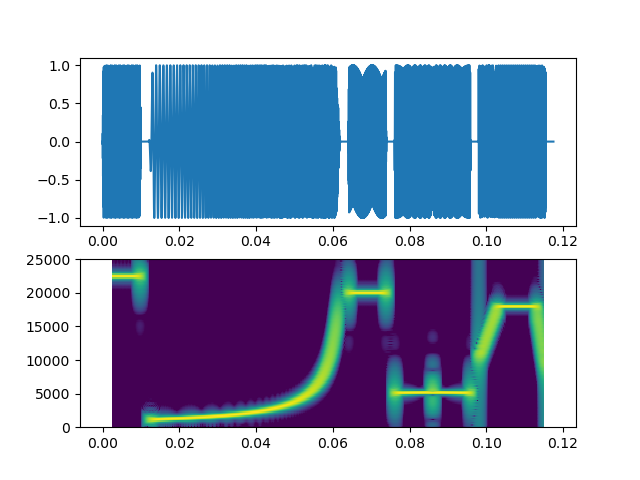

(<matplotlib.axes._subplots.AxesSubplot at 0x48c68d08>,
 <matplotlib.axes._subplots.AxesSubplot at 0x48c95fc8>)

In [40]:
visualise_call(multicomp_call, syn_fs, fft_size=256)

In [10]:
raw_fp, noise_sup_fp, clean_fp = get_clean_pwvd_frequency_profile(multicomp_call, syn_fs,
                                                                          background_noise=-9,
                                                                         window_size=50,
                                                                         min_element_length=0.5*10**-3,
                                                                         percentile=99)

In [11]:
mcomp_pwvd =  abs(pwvd_transform(multicomp_call, syn_fs))

In [12]:
peak, res = get_peak_frequency(multicomp_call, syn_fs)

<IPython.core.display.Javascript object>


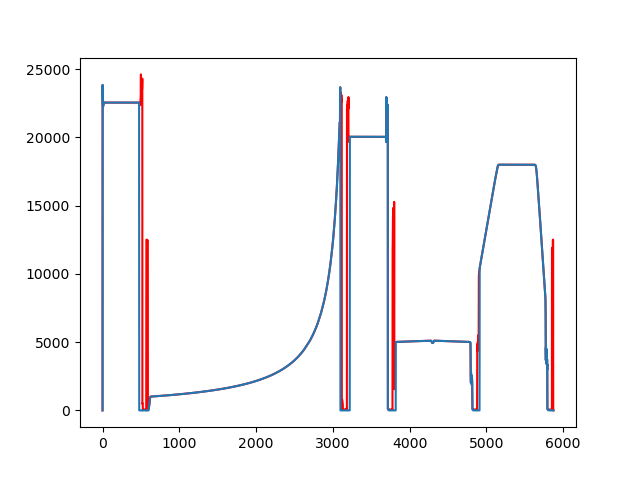

In [39]:
plt.figure()
plt.plot(raw_fp,'r')
plt.plot(noise_sup_fp)




In [14]:
4444-4319

125

In [15]:
audio_fr = multicomp_call.size/syn_fs
mindelta_per_sample = 100/syn_fs
expected_repetition = audio_fr/mindelta_per_sample

In [16]:
print(audio_fr, mindelta_per_sample, expected_repetition)

0.1175 0.002 58.74999999999999


In [17]:
multicomp_call

array([-4.50516607e-06,  4.80179770e-03, -3.59256999e-02, ...,
       -3.12535376e-05,  3.29939962e-06, -5.29959367e-06])

<IPython.core.display.Javascript object>


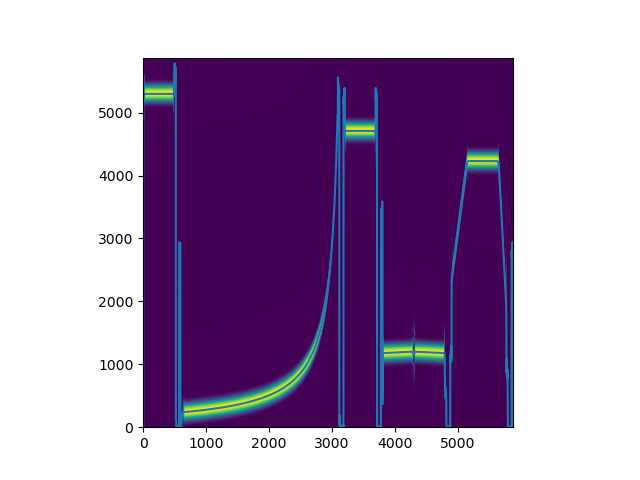

In [38]:
plt.figure()
plt.imshow(mcomp_pwvd, origin='lower')
indx = find_lowest_intense_harmonic_across_TFR(mcomp_pwvd, percentile=99)
plt.plot(indx)


In [19]:
clean_fp

array([    0.        , 23838.10010215, 23059.24412666, ...,
           0.        ,     0.        ,     0.        ])

In [20]:
call_parts = split_into_call_parts(clean_fp)

<IPython.core.display.Javascript object>


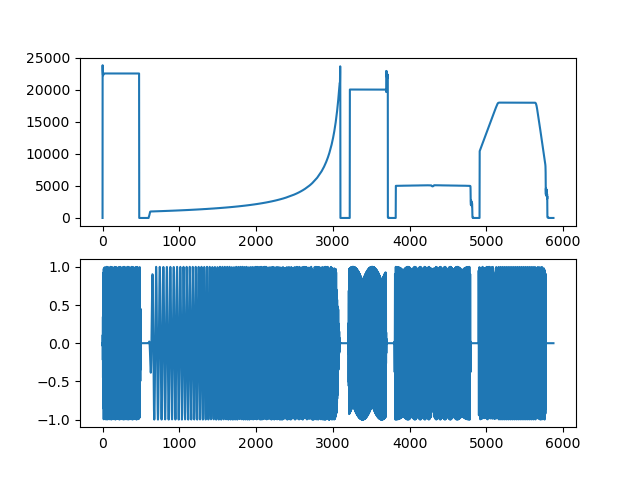

(slice(1, 477, None),)
(slice(601, 3098, None),)
(slice(3221, 3728, None),)
(slice(3820, 4829, None),)
(slice(4912, 5811, None),)


In [37]:
plt.figure()
a=plt.subplot(211)
#plt.plot(noise_sup_fp)
plt.plot(clean_fp)
for each in call_parts:
    print(each)
plt.subplot(212, sharex=a)
plt.plot(multicomp_call)

### Inspecting each call part:

<IPython.core.display.Javascript object>


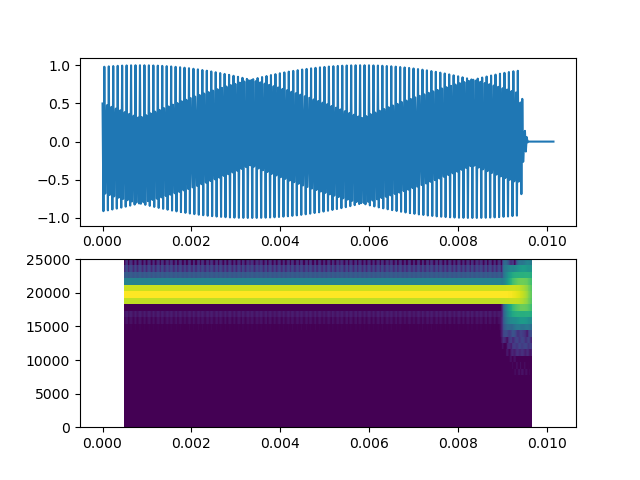

<IPython.core.display.Javascript object>


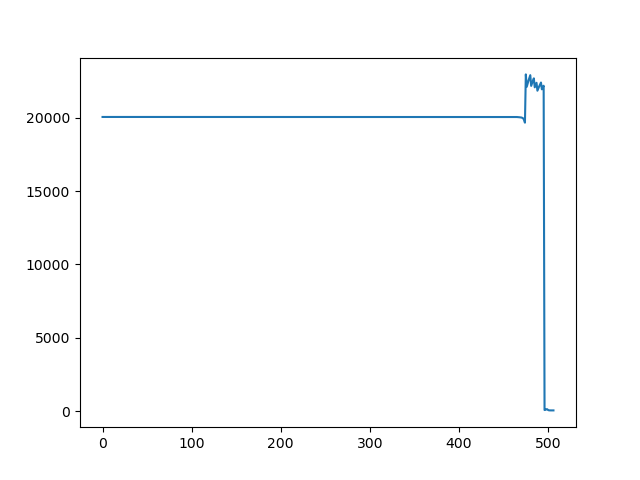

In [36]:
index = 2
part_audio = multicomp_call[call_parts[index]]
part_fp = clean_fp[call_parts[index]]
w,s = visualise_call(part_audio, syn_fs)
plt.figure()
plt.plot(part_fp)

In [23]:
150/syn_fs

0.003

<IPython.core.display.Javascript object>


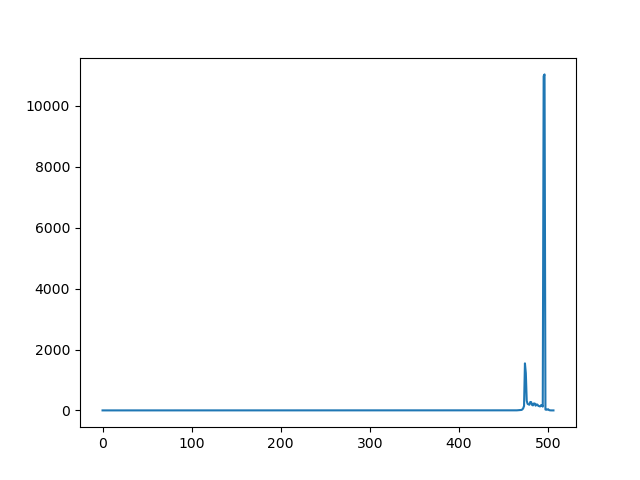

In [34]:
plt.figure()
plt.plot(abs(np.gradient(part_fp)))
    

In [25]:
int(0.0005*syn_fs)/syn_fs

0.0005

In [26]:
1/0.0005

2000.0

In [27]:
b,a = signal.butter(2, 500/(syn_fs*0.5),'lowpass')
bp_part = signal.filtfilt(b,a,part_fp)

<IPython.core.display.Javascript object>


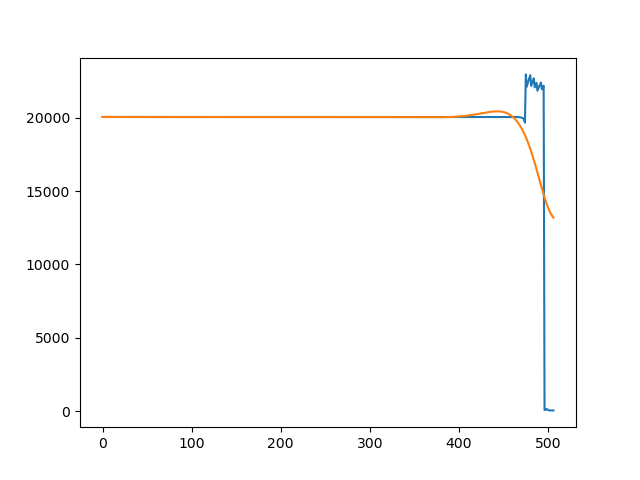

In [33]:
plt.figure()
plt.plot(part_fp)
plt.plot(bp_part)


In [29]:
fp_velocity = abs(np.gradient(bp_part))
fp_v_raw = abs(np.diff(part_fp))

b,a = signal.butter(2, 750/(syn_fs*0.5),'lowpass')
bp_fpv = signal.filtfilt(b,a,fp_velocity)

In [30]:
1/(50/syn_fs)

1000.0

<IPython.core.display.Javascript object>


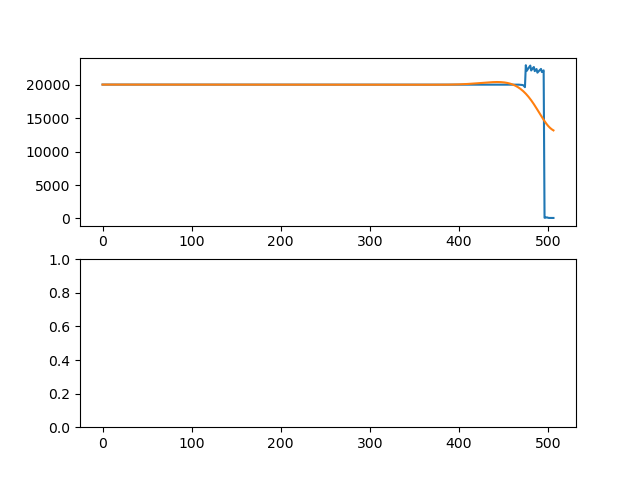

NameError: name 'isi' is not defined

In [32]:
plt.figure()
a= plt.subplot(211)
plt.plot(part_fp)
plt.plot(bp_part)

plt.subplot(212,sharex=a)
plt.plot(fp_velocity/isi)
plt.plot(bp_fpv/isi)


In [ ]:
def segment_each_call_part(call_parts, frequency_profile, fs, **kwargs):
    fm_threshold = kwargs.get('fm_threshold', 20000)

    cf_fm_parts = []
    fm_rates = []
    frequency_profiles = []
    for call_part in call_parts:
        part_frequency_profile = frequency_profile[call_part]
        delta_freq = abs(np.diff(part_frequency_profile))/(1.0/fs)
        smooth_deltafreq_profile = filters.percentile_filter(delta_freq, 50, int(fs*0.0005) )
        cf = smooth_deltafreq_profile <= fm_threshold
        fm = smooth_deltafreq_profile > fm_threshold
        cf_fm_parts.append([cf,fm])
        fm_rates.append(smooth_deltafreq_profile)
        frequency_profiles.append(part_frequency_profile)
    return cf_fm_parts, [fm_rates,frequency_profiles]



In [ ]:
cf_fm_parts,_ = segment_each_call_part(call_parts, clean_fp, syn_fs)

In [ ]:
plt.figure()
plt.plot(clean_fp)
for segmentation, region in zip(cf_fm_parts, call_parts):
    cf,fm = segmentation
    startstop = np.arange(region[0].start, region[0].stop-1)
    plt.plot(startstop,cf*15000, '-.g')
    plt.plot(startstop,fm*10000, '-*r', )
    plt.hlines(18000,startstop[0],startstop[-1])


In [ ]:
startstop[0],startstop[1]

### The PWVD method with our own horseshoe bat data:

In [ ]:
from measure_horseshoe_bat_calls import data

In [ ]:
audio, fs  = data.example_calls[1]
#b,a = signal.butter(2, np.array([25000,80000])/(fs*0.5), 'bandpass')
#audio  = signal.filtfilt(b,a,audio)
w,s = visualise_call(audio,fs)

In [ ]:
100/44100

In [ ]:
fs*20*10**-6

In [ ]:
raw_fp, noise_sup_fp, clean_fp = get_clean_pwvd_frequency_profile(audio, fs,
                                                                          background_noise=-40,
                                                                         min_element_length=1*10**-5,
                                                                         fm_threshold=5000,
                                                                         median_filter_size=0.001,
                                                                         percentile=99.5,
                                                                         pwvd_filter=False)
call_parts = split_into_call_parts(clean_fp)
cf_fm_parts, fmrate = segment_each_call_part(call_parts, clean_fp, fs)
#s.set_ylim(0,125000)
fmrate, freq_profile = fmrate

peak, _ = get_peak_frequency(audio, fs)
for segmentation, region, fp in zip(cf_fm_parts, call_parts, freq_profile):
    cf,fm = segmentation
    startstop = np.arange(region[0].start, region[0].stop-1)/fs
    s.plot(startstop,cf*peak*0.9, '-g')
    s.plot(startstop,fm*peak*0.5, '-r', )
    s.plot(startstop,fp[:-1])


In [ ]:
pwvd = np.abs(pwvd_transform(audio, fs))


In [ ]:
plt.figure()
q = plt.subplot(111)
q.imshow(dB(pwvd), origin='lower')

In [ ]:
for segmentation, region, fp in zip(cf_fm_parts, call_parts, freq_profile):
    cf,fm = segmentation
    startstop = np.arange(region[0].start, region[0].stop-1)
    q.plot(startstop,fp[:-1]/(2*res),'k')

In [ ]:
miaow[0].start

In [ ]:
colnum = 2660
plt.figure()

for i in range(3):
    col = abs(pwvd[:,colnum+i])
    plt.subplot(211)
    threshold = np.percentile(col, 98.5)
    plt.plot(col)
    plt.hlines(threshold, 0, 2000)
    plt.xlim(0,2000)
    plt.subplot(212)
    smooth = filters.percentile_filter(col, 50, 50)
    smooth_thres = np.percentile(smooth, 98.5)
    plt.plot(smooth)
    plt.hlines(smooth_thres, 0, 2000)
    plt.xlim(0,2000)
    
    


In [ ]:
miaow = find_loudest_harmonic_across_TFR(abs(pwvd),percentile=99)
miaow

In [ ]:
help(suppress_background_noise)

In [ ]:
skimage.__version__

In [ ]:
help(suppress_background_noise)

In [ ]:
miaow_bg_supp = suppress_background_noise(miaow, audio)

In [ ]:
twod_median_filter = filters.median_filter(abs(pwvd), size=(10,10))

In [ ]:
plt.figure()
plt.imshow(dB(twod_median_filter), origin='lower')

In [ ]:
miaow_med = find_loudest_harmonic_across_TFR(twod_median_filter,percentile=99)
miaow_med

In [ ]:
plt.figure()
plt.imshow(dB(twod_median_filter),origin='lower')
plt.plot(miaow_med)
#plt.plot(miaow_bg_supp)

In [ ]:
plt.figure()
plt.plot(miaow)
plt.plot(miaow_med)

In [ ]:
one_col = abs(pwvd[:,4266])

input_signal = one_col.copy()
percentile = 97.5
threshold = np.percentile(input_signal, percentile)
above_threshold  = input_signal > threshold
regions, num_regions = scipy.ndimage.label(above_threshold)
region_locations = scipy.ndimage.find_objects(regions)

plt.figure()
plt.plot(one_col)
plt.hlines(threshold, 0 ,7000)
for i,each in enumerate(region_locations):
    plt.plot(np.arange(each[0].start, each[0].stop), np.tile(threshold,one_col[each].size), label=str(i))
plt.legend()

In [ ]:
a,b = two_plot_w_top_refx(one_col, ac_onecol)


In [ ]:
def get_peaks_by_AC()

In [ ]:
plt.figure()
plt.imshow(dB(abs(pwvd)), origin='lower')

In [ ]:
import skimage


In [ ]:
skimage.__version__

In [ ]:
plt.figure()
plt.plot(noise_sup_fp)


In [ ]:
### smoothed PWVD

### How about the idea of taking only N points along the signal and fitting a spline to this data - resampling it to the full length and then calcualting the rate of FM?

In [ ]:
isi = 1/syn_fs
index = 2
part_frequency_profile = clean_fp[call_parts[index]]

a_few_points = np.concatenate((np.array([0]),
                              np.arange(1,part_frequency_profile.size-5,15),
                              np.array([part_frequency_profile.size-1])))

spline_fit = scipy.interpolate.interp1d(a_few_points, part_frequency_profile[a_few_points], 1)
smoothed_fp  = spline_fit(np.arange(part_frequency_profile.size))
deltaf = np.abs(np.diff(smoothed_fp))/isi
grad = np.abs(np.gradient(smoothed_fp,2))/isi
pctile_grad = filters.percentile_filter(grad, 50, int(0.0005*syn_fs))
plt.figure()
a=plt.subplot(211)
plt.plot(smoothed_fp)
plt.subplot(212, sharex=a)
plt.plot(grad)
plt.plot(deltaf)
plt.plot(pctile_grad)

In [ ]:
b,a = signal.butter(1, 0.02, 'lowpass')

bp_fp = signal.filtfilt(b,a, part_frequency_profile)

a,b = two_plot_w_top_refx(bp_fp, part_frequency_profile)


In [ ]:
plt.figure()
plt.plot(np.abs(np.diff(part_frequency_profile))/isi)